In [30]:
from Methods.utils import BaseCommunityDetection
import numpy as np
import pandas as pd
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
class SOM(BaseCommunityDetection):
    '''
        Template class for community detection methods.
        The dtype parameter can be either 'featured' or 'main'.
        It is used to determine which data to use.

        All parameters of the model that you would want to tune should be passed in the constructor (i.e. __init__).

        Some useful methods include:
        - self.get_member_country() -> np.ndarray
        - self.get_member_vote() -> np.ndarray
        - self.get_vote_country() -> np.ndarray
        - self.get_country_country() -> np.ndarray
        - self.sorted_eigh(A) -> Tuple[np.ndarray, np.ndarray]
        - self.matrix_power(A, n) -> np.ndarray (Well defined only for positive definite matrices)

        All these methods have some optional parameters. Check the Data class for more information.
    '''
    def __init__(self, grid_size = 20, locality = 1/2, dtype = 'featured'):
        self.name = "Self Organizing Map"
        self.grid_size = grid_size
        self.locality = locality
        super().__init__(dtype)
        self.data = np.log(1/2 + self.get_vote_country(normalize=True))
        num_votes = self.data.shape[0]
        self.grid = np.random.uniform(0, 1, (grid_size, grid_size, num_votes))

    def calculate_weights(self, x, y):
        # idea, this induces a flat geometry on the grid, maybe try a torus or a sphere?
        # sphere is probably too difficult to implement
        # torus is probably easier
        grid_indices = np.indices((self.grid_size, self.grid_size)) - np.array([x, y])[:, None, None]
        grid_indices = np.minimum(np.abs(grid_indices), self.grid_size - np.abs(grid_indices))
        return np.exp(-np.sum(grid_indices**2, axis=0)*self.locality)
    
    def distance_torus(self, x1, y1, x2, y2):
        x_dist = np.abs(x1 - x2)
        y_dist = np.abs(y1 - y2)
        return np.minimum(x_dist, self.grid_size - x_dist)**2 + np.minimum(y_dist, self.grid_size - y_dist)**2

    def one_step(self):
        delta_grid = np.zeros_like(self.grid)
        for j in range(self.data.shape[1]):
            distances = np.sum((self.grid - self.data[:, j])**2, axis=2)
            x,y = np.unravel_index(np.argmin(distances), (self.grid_size, self.grid_size))
            weight = 0.1 * self.calculate_weights(x, y)
            delta_grid += weight[:, :, None] * (self.data[:, j] - self.grid)
        self.grid += delta_grid
        return np.linalg.norm(delta_grid)
    
    def fit(self, n_iter = 1000):
        '''
        Saves a pd.DataFrame in the attribute called self.labels with the following columns:
        - "Name"  - Country name
        - "Label" - Cluster number
        '''
        norm_delta = 1
        for _ in (pbar := trange(n_iter)):
            if norm_delta < 1e-5:
                break
            norm_delta = self.one_step()
            pbar.set_description(f"Norm Delta: {norm_delta}")

        self.embedding = np.zeros((self.data.shape[1], 2))
        for i in range(self.data.shape[1]):
            x, y = np.unravel_index(np.argmin(np.sum((self.grid - self.data[:, i])**2, axis=2)), (self.grid_size, self.grid_size))
            self.embedding[i] = [x, y]

        self.distance_matrix = np.zeros((self.data.shape[1], self.data.shape[1]))
        for i in range(self.data.shape[1]):
            for j in range(i, self.data.shape[1]):
                self.distance_matrix[i, j] = self.distance_torus(*self.embedding[i], *self.embedding[j])
                self.distance_matrix[j, i] = self.distance_matrix[i, j]
        assert np.allclose(np.diag(self.distance_matrix), 0)
        H = np.eye(self.data.shape[1]) - np.ones((self.data.shape[1], self.data.shape[1]))/self.data.shape[1]
        B = -H @ self.distance_matrix @ H / 2
        eval, evec = self.sorted_eigh(B)
        eval = np.maximum(eval, 0)
        self.embedding = evec[:, :2] * np.sqrt(eval[:2])


        self.labels = pd.DataFrame({
            "Name": self.country_names,
            "Label": self.generate_labels()
        })
        return self
    
    def visualize_weights(self, pt = None):
        if pt is None:
            x = y = self.grid_size/2
        else:
            x, y = pt
        return self.calculate_weights(x, y)


<Axes: >

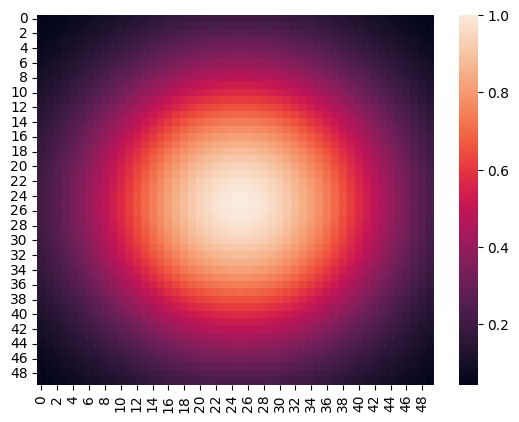

In [32]:
model = SOM(grid_size=50, locality=1/400)
sns.heatmap(model.visualize_weights())

Norm Delta: 3.6667667396998738: 100%|██████████| 400/400 [00:31<00:00, 12.86it/s]


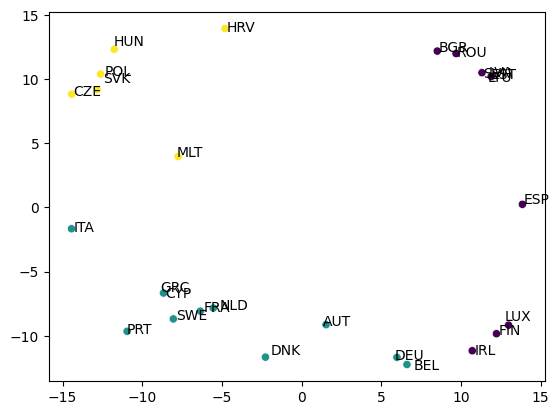

In [33]:
model.fit(n_iter=400)

def label_point(xs, ys, vals, ax):
        for x, y, val in zip(xs, ys, vals):
            x, y = x + np.random.normal(0, 1/4), y + np.random.normal(0, 1/4)
            ax.text(x, y, val)

def plot_countries(labels, embedding):
    xs = embedding[:, 0]
    ys = embedding[:, 1]
    label = labels.loc[:, "Label"]

    sns.scatterplot(x = xs, y = ys, c = label)
    # plt.axis('equal')

    label_point(xs, ys, labels.Name, plt.gca())

plot_countries(model.labels, model.embedding)

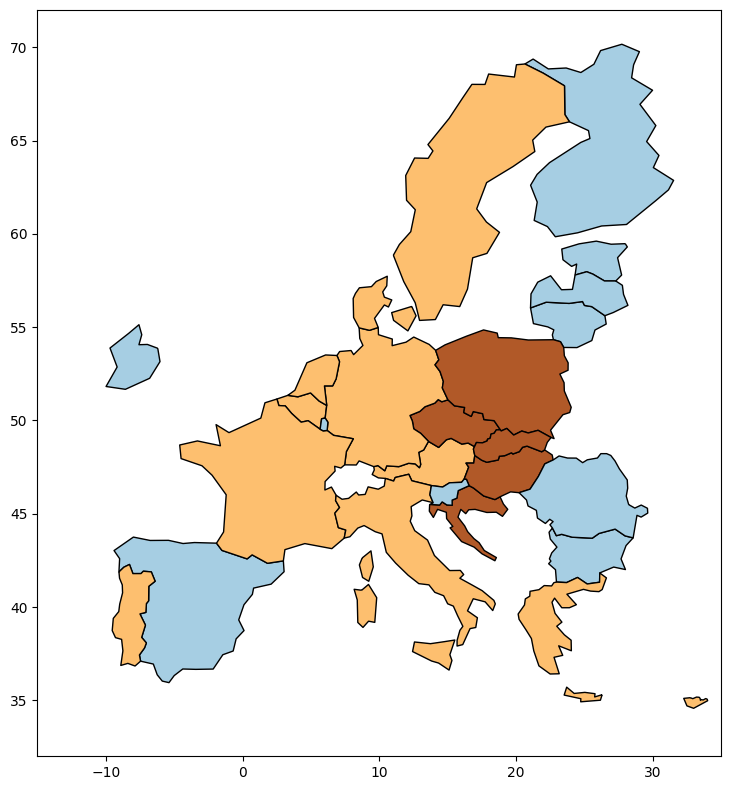

In [34]:
europe = model.get_europe_df()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# create the plot
europe.plot(ax = ax, 
            edgecolor = "black",
            column = "Label",
            cmap = "Paired",
            categorical = True,
)

# custom axis
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)

# display the plot
plt.tight_layout()
plt.show()